# Machine Failure Prediction

# Imports

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as sklearnPipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve as sklearn_roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [109]:
def check_nulls_dupes(df):
  print(f"The amount of nulls: {df.isna().sum()}")
  print(f"The amount of Dupes: {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  rows = len(df.columns)
  dims = (rows+ 3)//4
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "Hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(16, 16))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.subplot(dims, 4, idx+1)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def plot_roc_curve(X,y, sample_model, model, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
  pipeline = create_pipeline(sample_model, model, kbest)
  
  pipeline.fit(X_train, y_train)
  y_scores = pipeline.predict_proba(X_test)[:, 1]
  
  fpr, tpr, thresholds = sklearn_roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)
  print(f"The AUC is: {roc_auc:.2f}")

  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

def create_pipeline(sample_model, model, kbest=None):
  
  steps = [
    ("Scaler", MinMaxScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("sample", sample_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature-Selector", kbest))
  
  return Pipeline(steps=steps)

def create_sklearn_pipeline( model):
  
  steps = [
    ("Scaler", MinMaxScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("model", model)
  ]
  
  return sklearnPipeline(steps=steps)

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="stratified")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(sample_model, model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_pipeline(sample_model, model, kbest) if kbest else create_pipeline(sample_model, model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

def test_kbest_columns(X, y, sample_model, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_pipeline(sample_model, model, metric)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  return pd.DataFrame(metric_tracker)

def pca_analysis(X):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  
  for n in features:
    pca = PCA(n_components=n)
    pipeline = create_sklearn_pipeline(pca)
    X_pca = pipeline.fit_transform(X)
    
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append({
      "Component":n,
      "CumSum":cumsum
    }
    )
    
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  print(performance_df)

def optimization_search(sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_pipeline(sample_model,model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker)

def test_voting_classifier(X,y, model, sample_model, kbest, model_name):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  model_pipeline = create_pipeline(sample_model,model, kbest)
  model_pipeline.fit(X_train, y_train)
  y_pred = model_pipeline.predict(X_test)
    
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
  plot_confusion_matrix(y_test, y_pred, model_name)
  metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker)

# EDA Analysis

In [76]:
df = pd.read_csv("/Users/maukanmir/downloads/data.csv")
df

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0
...,...,...,...,...,...,...,...,...,...,...
939,0,7,7,1,6,4,73,6,24,1
940,0,7,5,2,6,6,50,6,24,1
941,0,3,6,2,7,5,43,6,24,1
942,0,6,6,2,5,6,46,7,24,1


# Check For Nulls & Dupes

In [77]:
check_nulls_dupes(df)

The amount of nulls: footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64
The amount of Dupes: 1


In [78]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

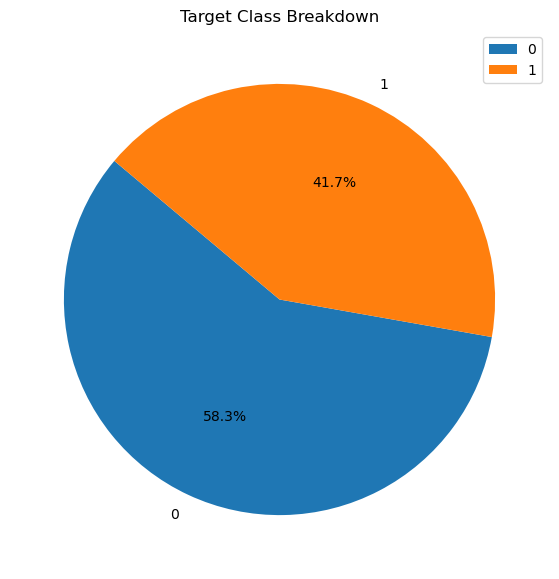

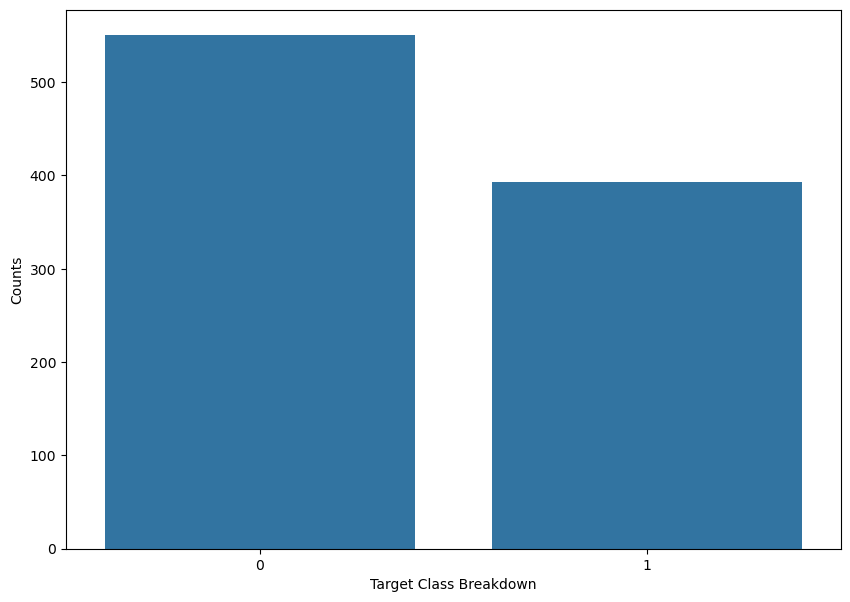

In [79]:
check_class_imbalance(df["fail"])

# Fairly Balanced Dataset

In [80]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
footfall,943.0,306.673383,1083.144024,0.0,1.0,22.0,110.0,7300.0
tempMode,943.0,3.726405,2.678334,0.0,1.0,3.0,7.0,7.0
AQ,943.0,4.326617,1.438551,1.0,3.0,4.0,6.0,7.0
USS,943.0,2.939555,1.384458,1.0,2.0,3.0,4.0,7.0
CS,943.0,5.393425,1.269869,1.0,5.0,6.0,6.0,7.0
VOC,943.0,2.844115,2.273751,0.0,1.0,2.0,5.0,6.0
RP,943.0,47.042418,16.431816,19.0,34.0,44.0,58.0,91.0
IP,943.0,4.564157,1.599452,1.0,3.0,4.0,6.0,7.0
Temperature,943.0,16.326617,5.976014,1.0,14.0,17.0,21.0,24.0
fail,943.0,0.416755,0.493283,0.0,0.0,0.0,1.0,1.0


In [81]:
df.dtypes

footfall       int64
tempMode       int64
AQ             int64
USS            int64
CS             int64
VOC            int64
RP             int64
IP             int64
Temperature    int64
fail           int64
dtype: object

# Visuals

<AxesSubplot:>

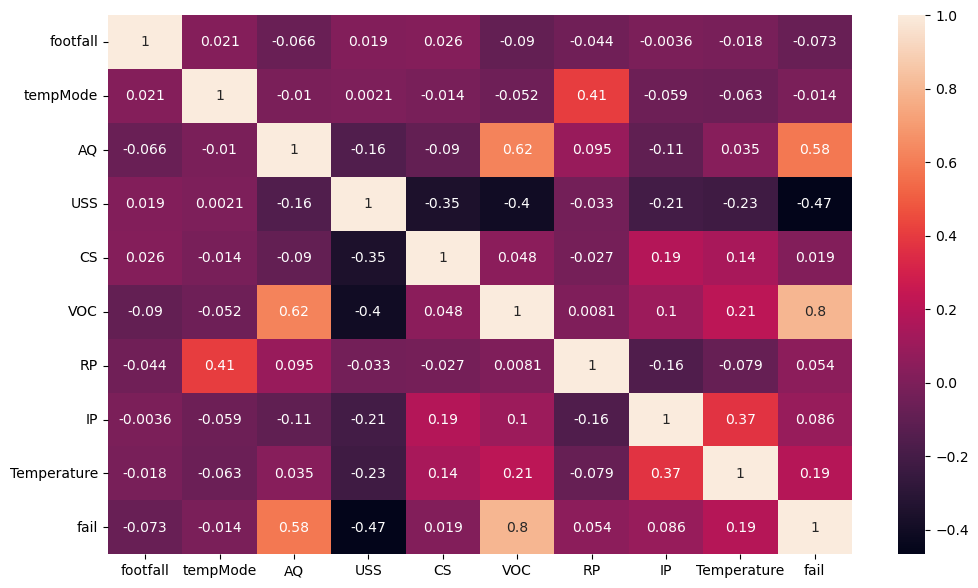

In [82]:
relations = df.corr()
plt.figure(figsize=(12, 7))
sns.heatmap(data=relations, annot=True)

# Histogram

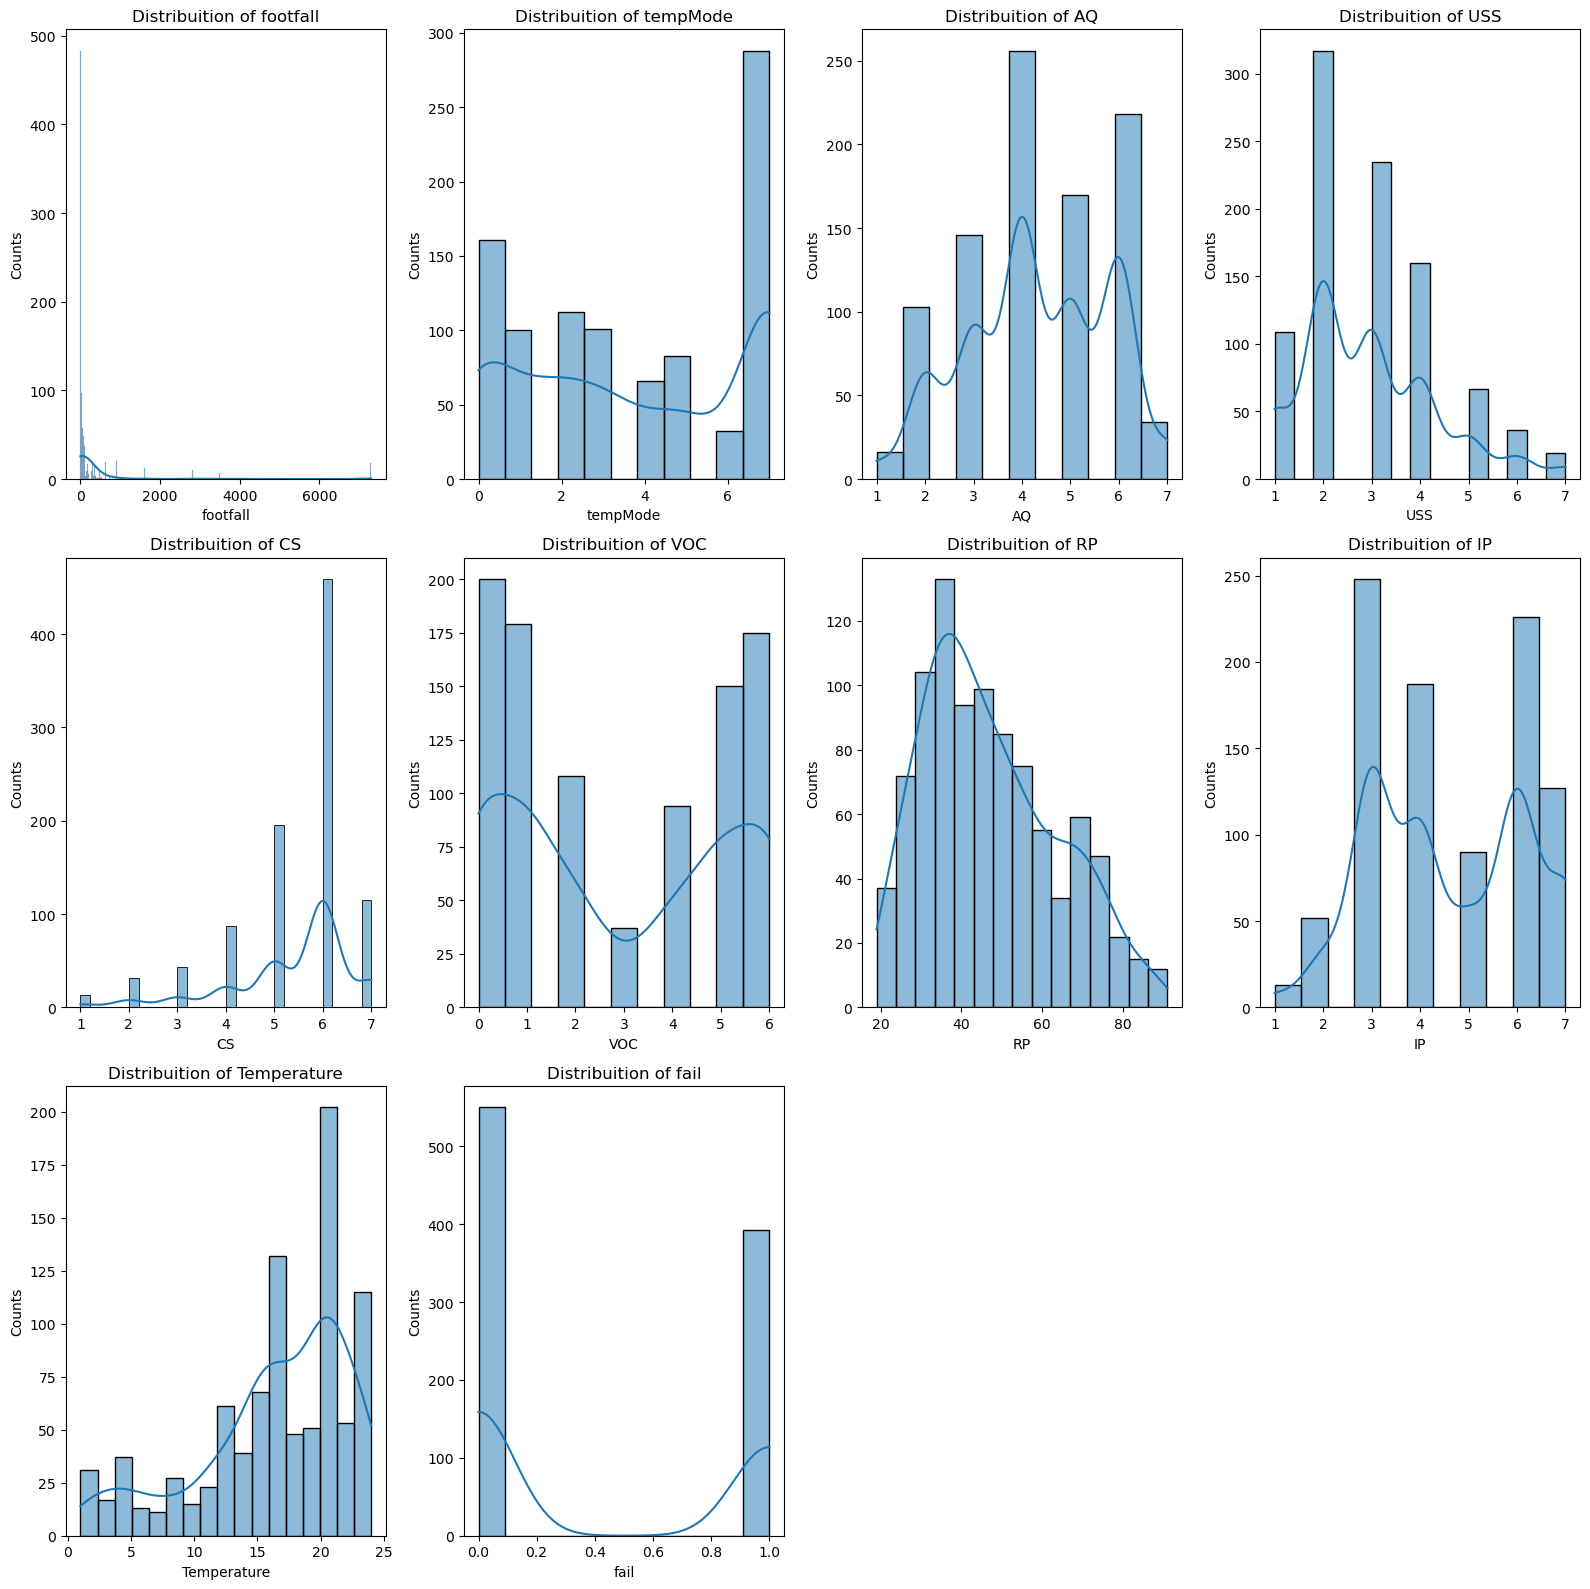

In [83]:
plot_distribution(df,"Hist")

# Boxplot

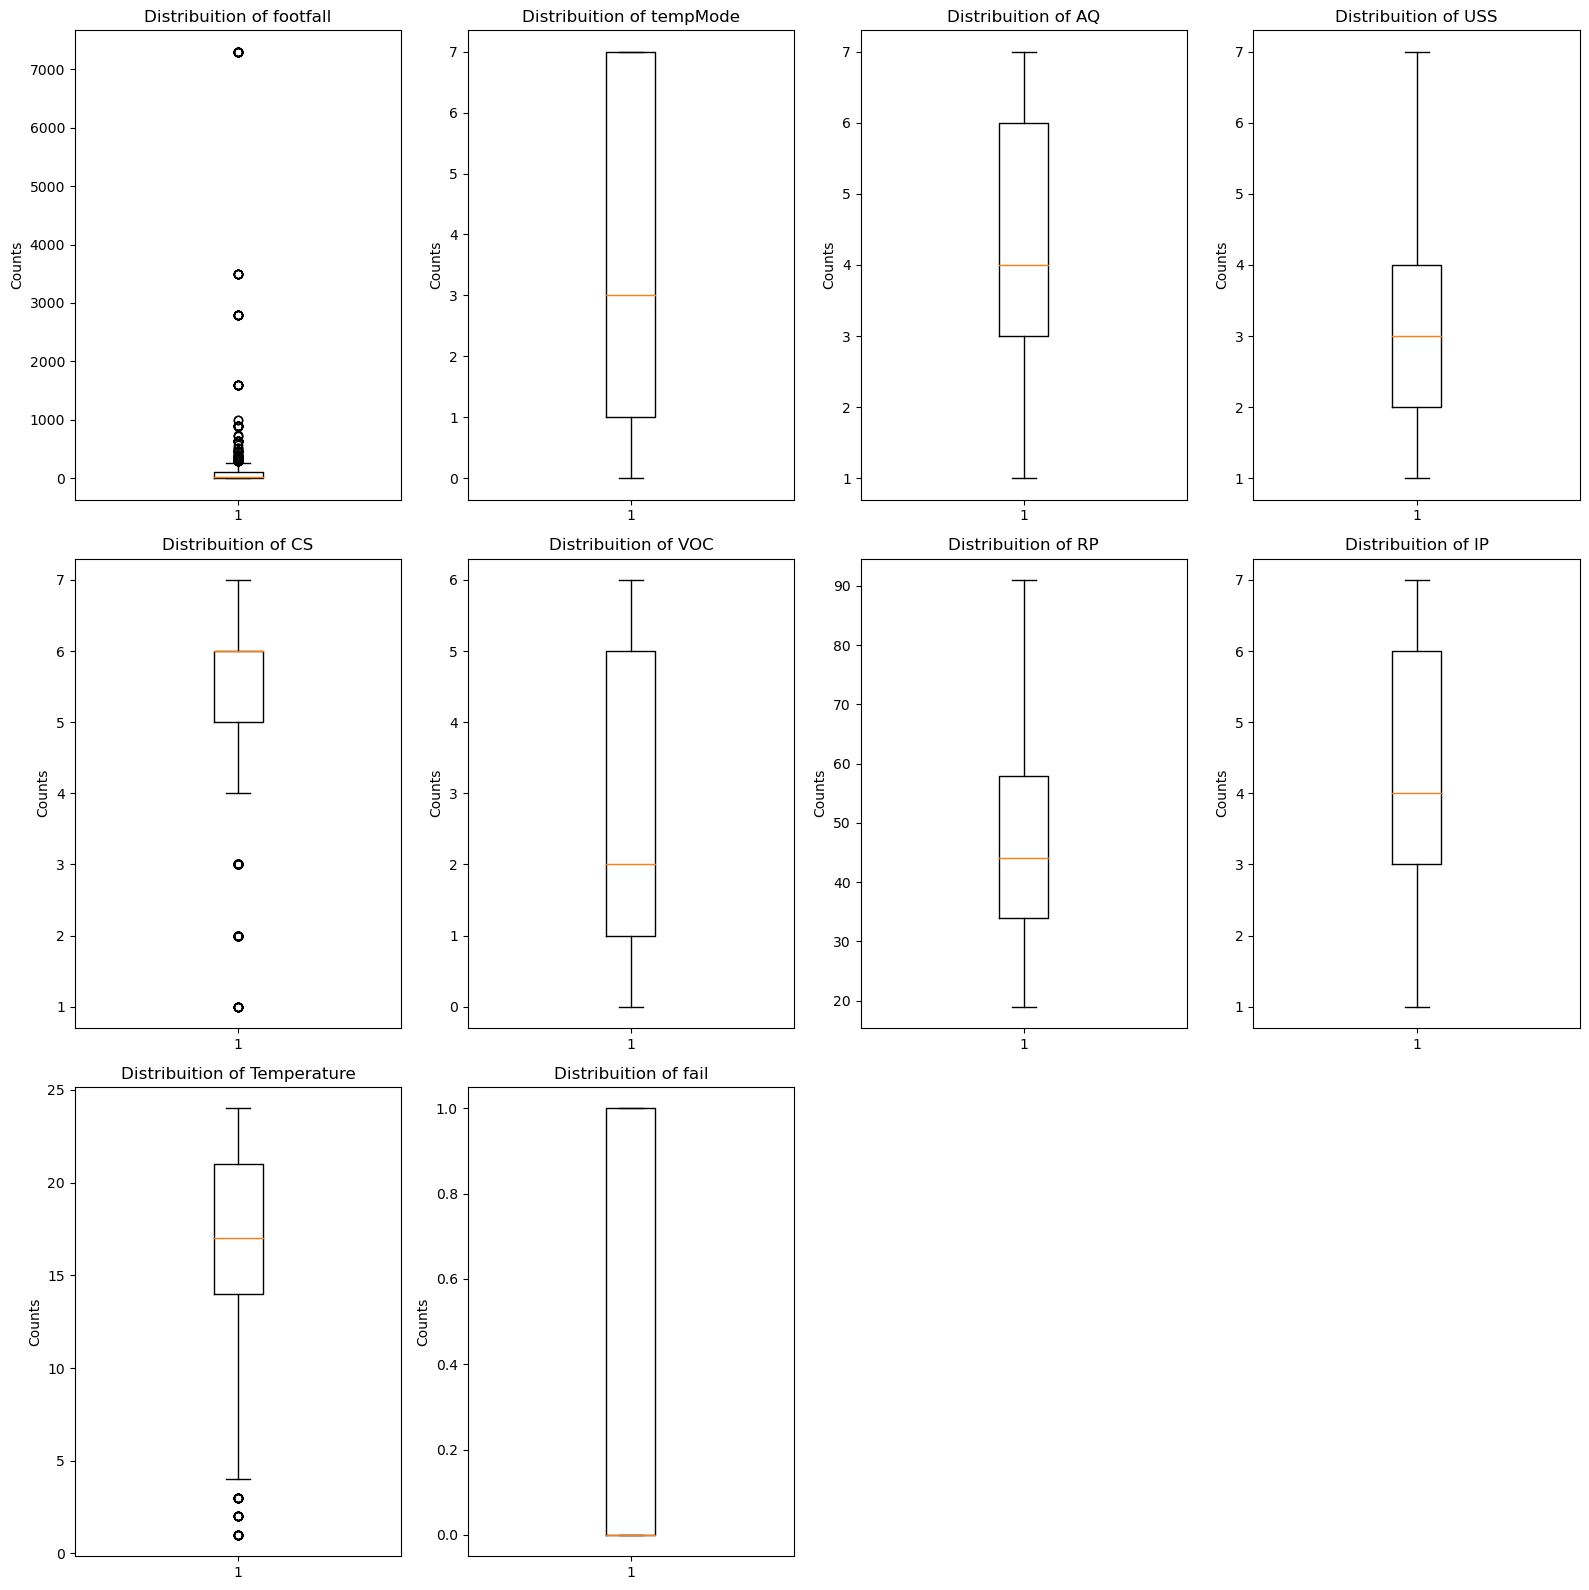

In [84]:
plot_distribution(df,"box")

# Aggregate Dataset

# Sum

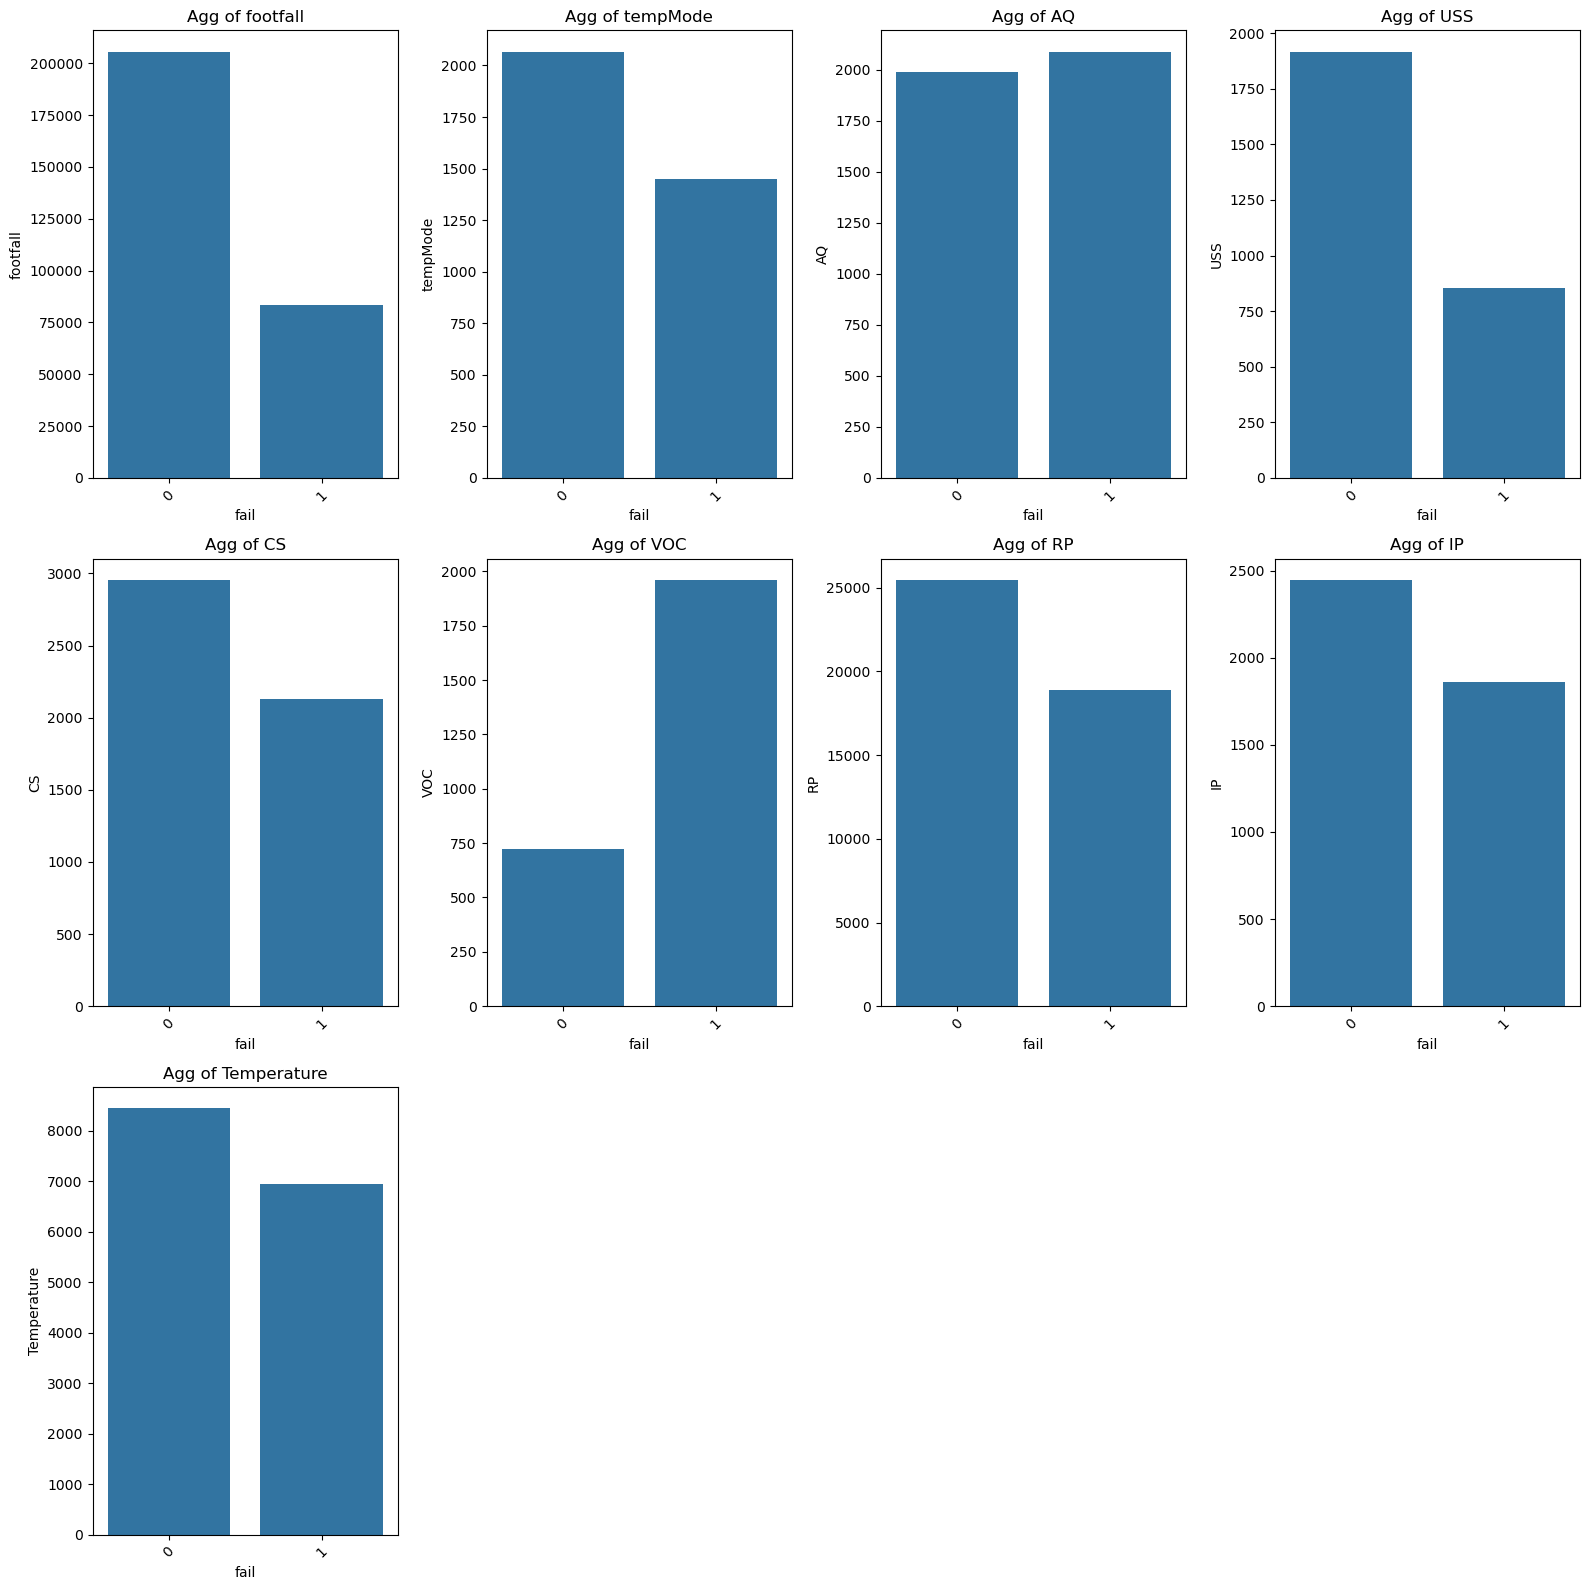

In [85]:
interested_columns = df.drop("fail", axis=1).columns

aggregate_dataset(df, interested_columns, "fail", "sum")

# Mean

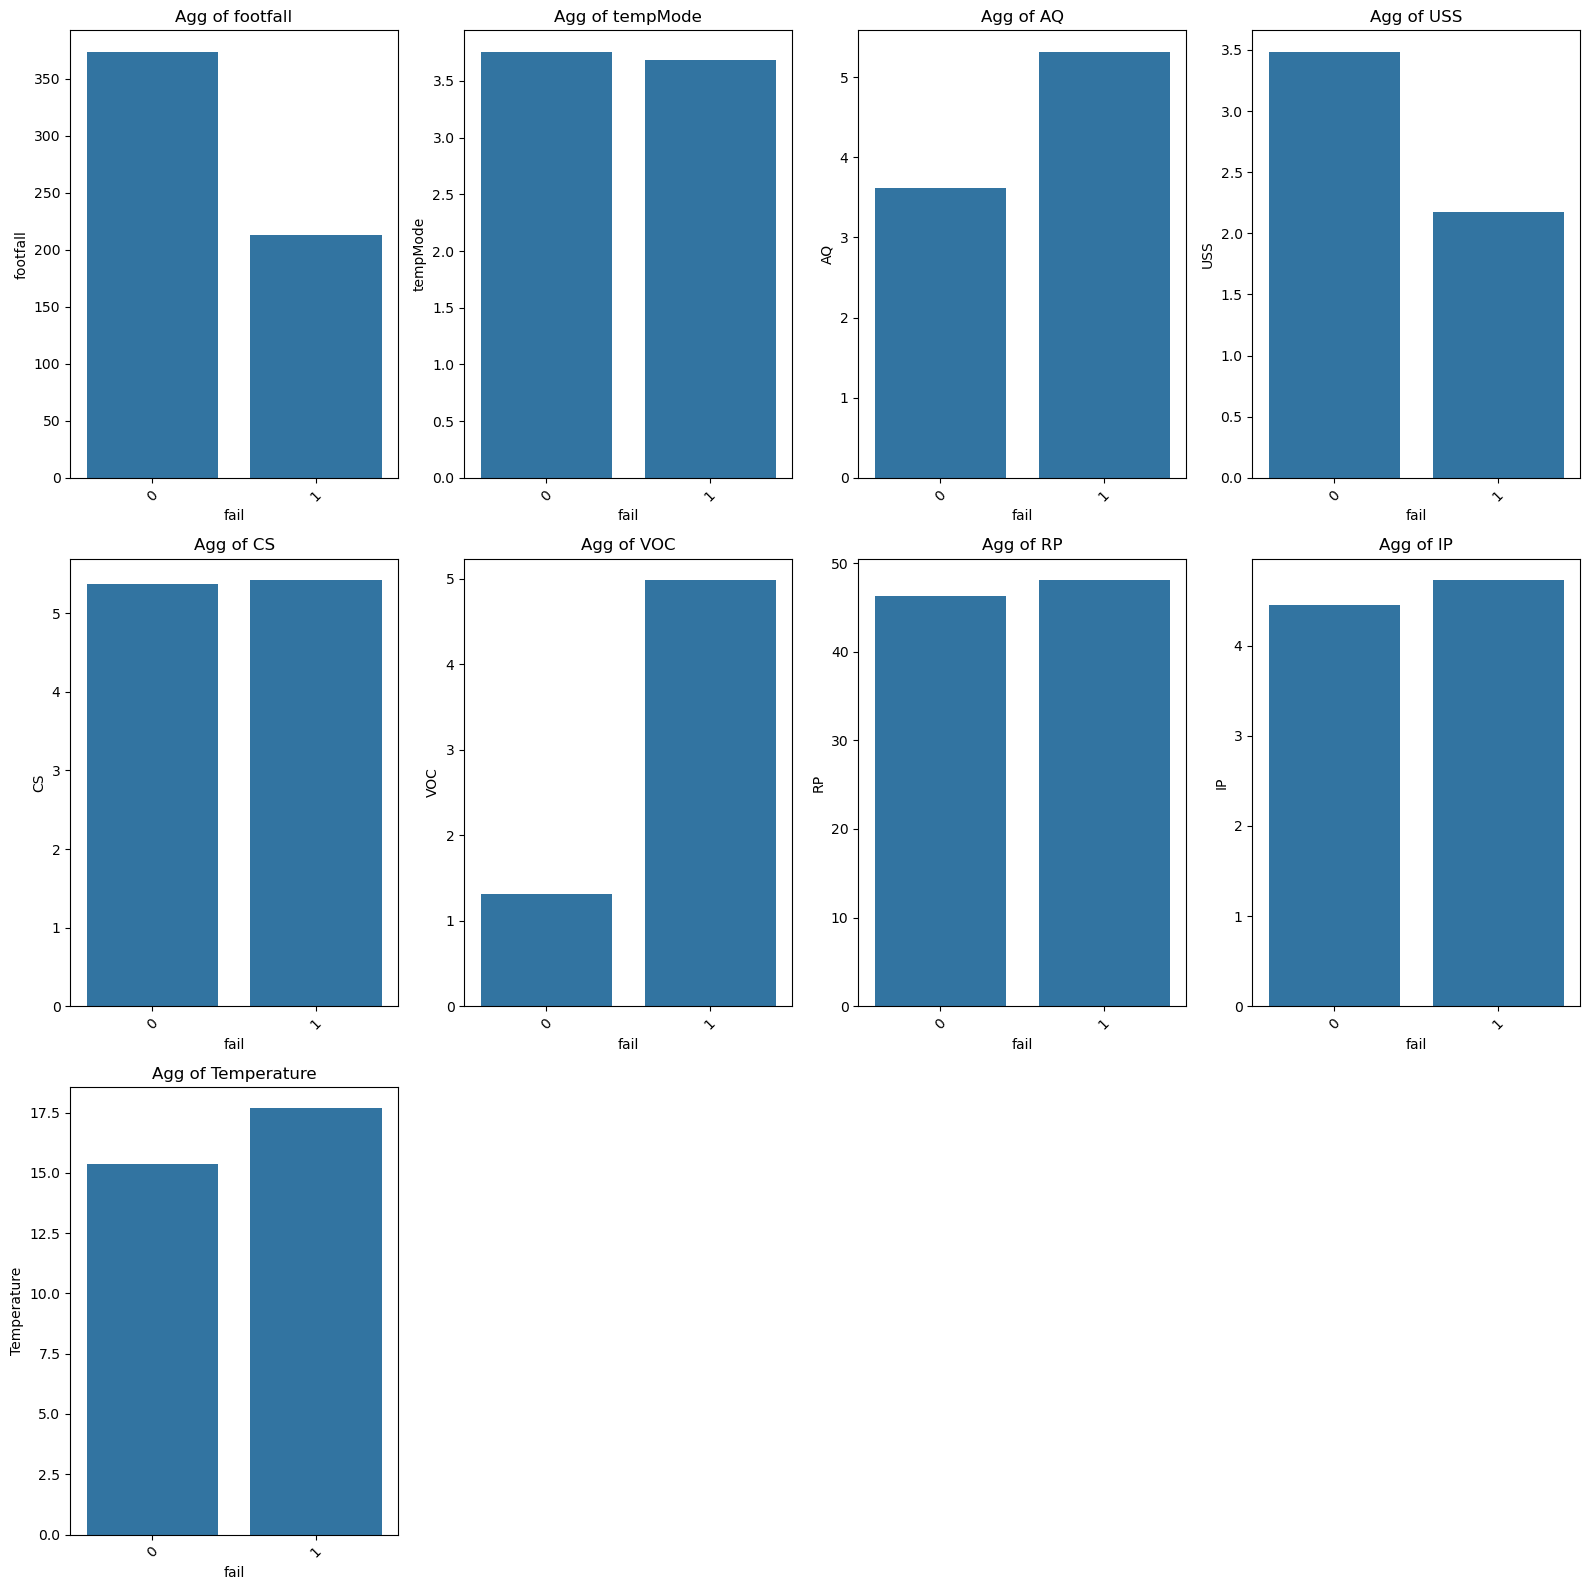

In [86]:
interested_columns = df.drop("fail", axis=1).columns

aggregate_dataset(df, interested_columns, "fail", "mean")

# Separate Variables

In [87]:
X = df.drop("fail", axis=1)
y = df["fail"]

# Create Metrics

In [88]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

# Baseline Model Performance

In [89]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
sample_model = SMOTE()
test_selected_models(sample_model, model_name, models, X, y, acc_metric)

   Model   Mean    Var    STD  Test-Acc  recall-Score  precision-Score  \
0  DUMMY  0.499  0.003  0.053      0.52          0.52            0.534   

   F1-Score  
0     0.523  


# PCA Analysis

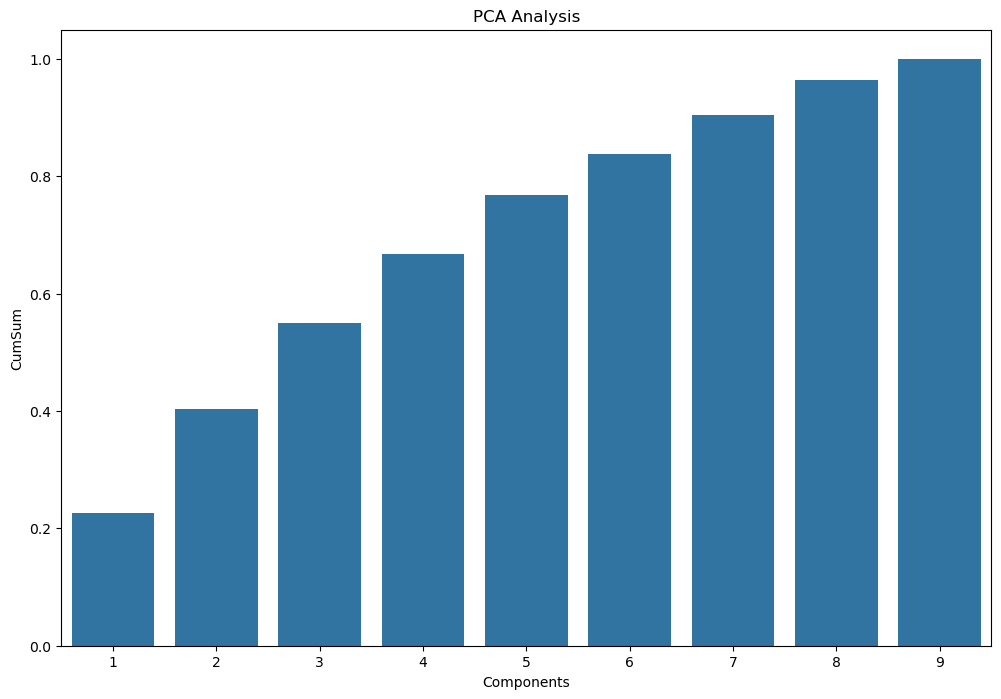

   Component    CumSum
0          1  0.226844
1          2  0.403995
2          3  0.550049
3          4  0.667514
4          5  0.767733
5          6  0.838227
6          7  0.904352
7          8  0.963728
8          9  1.000000


In [90]:
pca_analysis(X)

# Test Kbest Columns

# Fstat

In [91]:
kbest = f_classif
model_name = ["LR"]
models = grab_selected_models(model_name)
test_kbest_columns(X, y, sample_model, models[0], model_name[0], kbest)

,Model,K,acc_metric,f1_metric,recall,precision
0,LR,1,0.887821,0.888603,0.887821,0.902674
1,LR,2,0.916667,0.917166,0.916667,0.922498
2,LR,3,0.913462,0.913812,0.913462,0.915696
3,LR,4,0.919872,0.920250,0.919872,0.922929
4,LR,5,0.919872,0.920296,0.919872,0.923929
5,LR,6,0.916667,0.917084,0.916667,0.920229
6,LR,7,0.903846,0.904380,0.903846,0.908565
7,LR,8,0.900641,0.901167,0.900641,0.904832
8,LR,9,0.903846,0.904269,0.903846,0.906561


In [92]:
kbest = mutual_info_classif
test_kbest_columns(X, y, sample_model, models[0], model_name[0], kbest)

,Model,K,acc_metric,f1_metric,recall,precision
0,LR,1,0.887821,0.888603,0.887821,0.902674
1,LR,2,0.916667,0.917166,0.916667,0.922498
2,LR,3,0.907051,0.907489,0.907051,0.910197
3,LR,4,0.916667,0.917129,0.916667,0.921296
4,LR,5,0.923077,0.923463,0.923077,0.926595
5,LR,6,0.913462,0.913919,0.913462,0.917563
6,LR,7,0.910256,0.910754,0.910256,0.914931
7,LR,8,0.903846,0.904380,0.903846,0.908565
8,LR,9,0.907051,0.907489,0.907051,0.910197


# Mutual Information performed the best

In [93]:
kbest = SelectKBest(score_func=mutual_info_classif, k=4)
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
test_selected_models(sample_model, model_names, models, X, y, f1_metric, kbest)

  Model   Mean    Var    STD  Test-Acc  recall-Score  precision-Score  \
1   SVC  0.912  0.001  0.028     0.911         0.911            0.912   
2   KNN  0.908  0.001  0.031     0.894         0.894            0.894   
0    LR  0.905  0.001  0.028     0.901         0.901            0.903   

   F1-Score  
1     0.911  
2     0.894  
0     0.902  


In [94]:
model_names = ["RFC", "XGB", "GBC"]
models = grab_selected_models(model_names)
test_selected_models(sample_model, model_names, models, X, y, f1_metric, kbest)

  Model   Mean    Var    STD  Test-Acc  recall-Score  precision-Score  \
2   GBC  0.907  0.001  0.028     0.865         0.865            0.867   
0   RFC  0.898  0.001  0.032     0.882         0.882            0.882   
1   XGB  0.898  0.001  0.031     0.823         0.823            0.824   

   F1-Score  
2     0.866  
0     0.882  
1     0.823  


# Hyper Parameter Tuning

In [95]:
params = {
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'model__criterion':["gini", "entropy"],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'LR': {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga']
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4]
    },
    'KNN': {
    'model__n_neighbors': [3, 5, 10, 15],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': [10, 30, 50],
    'model__p': [1, 2]
}
}

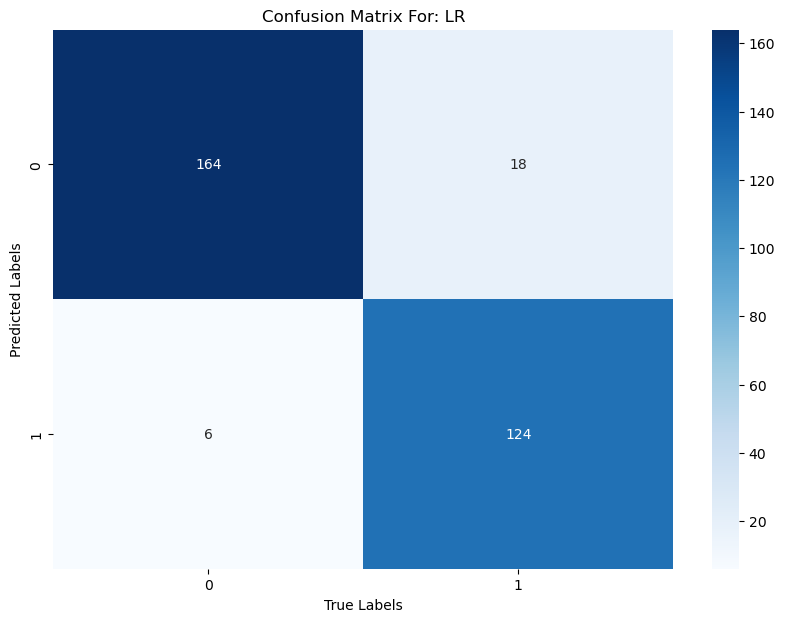

The Best Param: {'model__solver': 'saga', 'model__penalty': 'l1', 'model__C': 1}


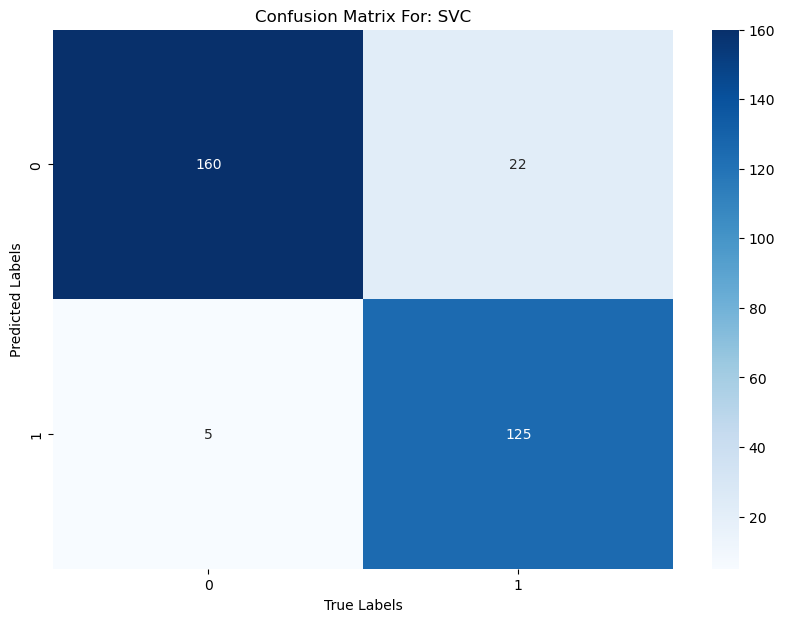

The Best Param: {'model__kernel': 'linear', 'model__gamma': 'auto', 'model__degree': 3, 'model__C': 10}


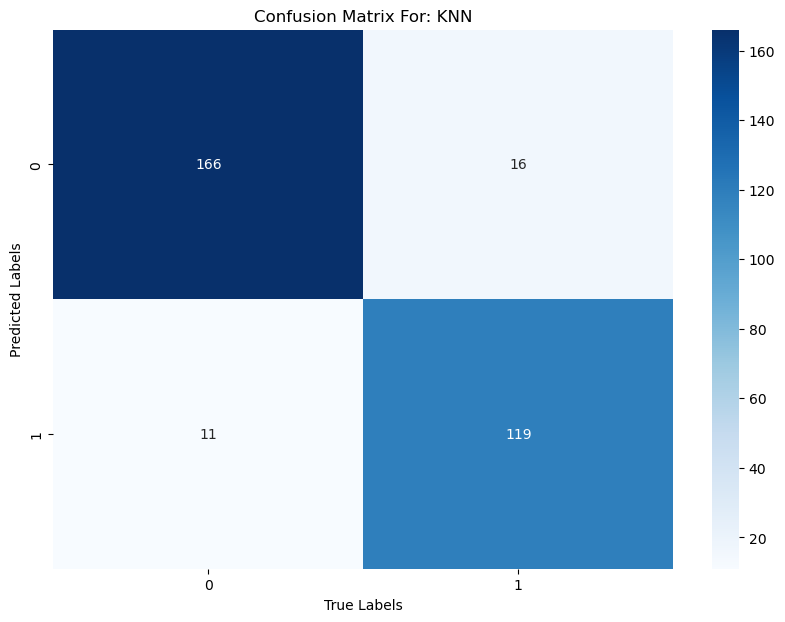

The Best Param: {'model__weights': 'uniform', 'model__p': 1, 'model__n_neighbors': 3, 'model__leaf_size': 10, 'model__algorithm': 'brute'}
  Model  Test-Acc  F1-Score  recall-Score  precision-Score
0    LR  0.923077  0.923463      0.923077         0.926595
1   SVC  0.913462  0.913997      0.913462         0.919965
2   KNN  0.913462  0.913675      0.913462         0.914365


In [96]:

model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
performance_df = optimization_search(sample_model, model_names, models, X, y, RandomizedSearchCV, params, f1_metric, kbest)
print(performance_df.sort_values(by="Test-Acc", ascending=False))

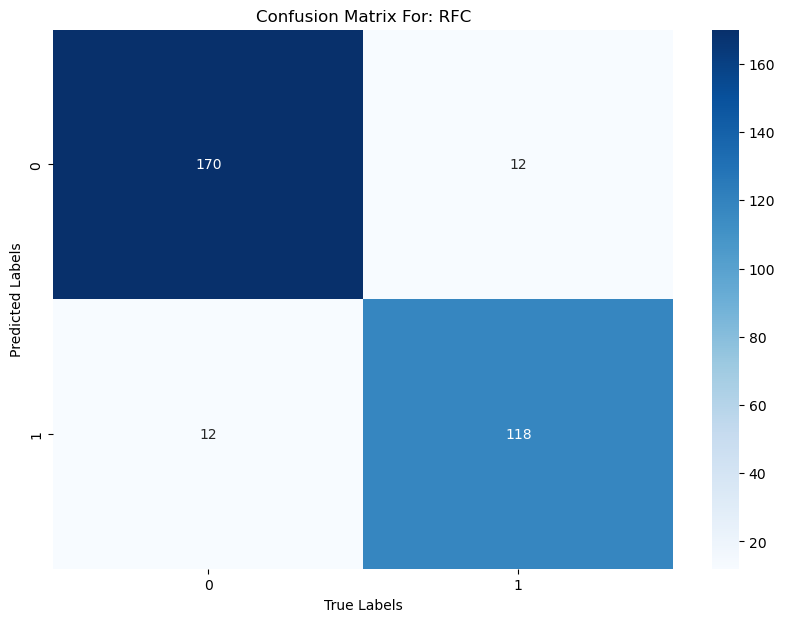

The Best Param: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': None, 'model__criterion': 'gini'}


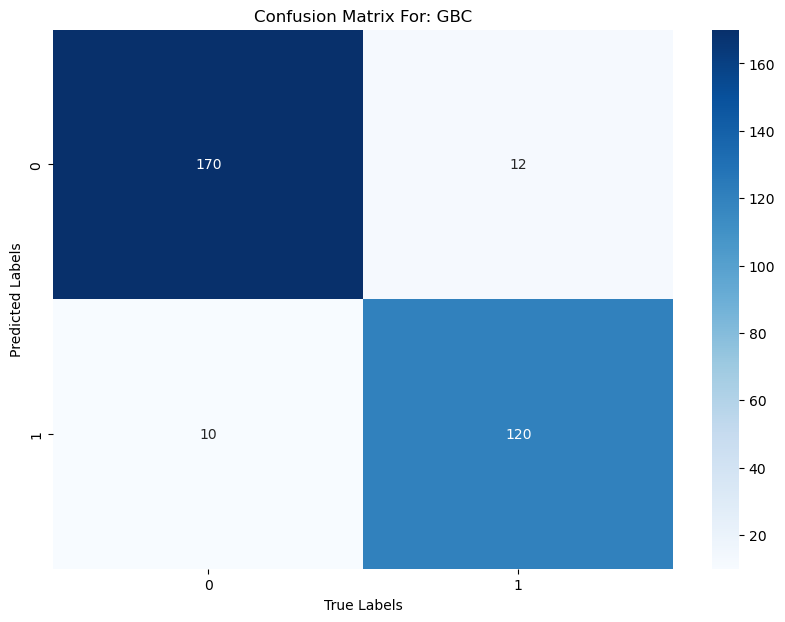

The Best Param: {'model__n_estimators': 300, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 3, 'model__learning_rate': 0.01}


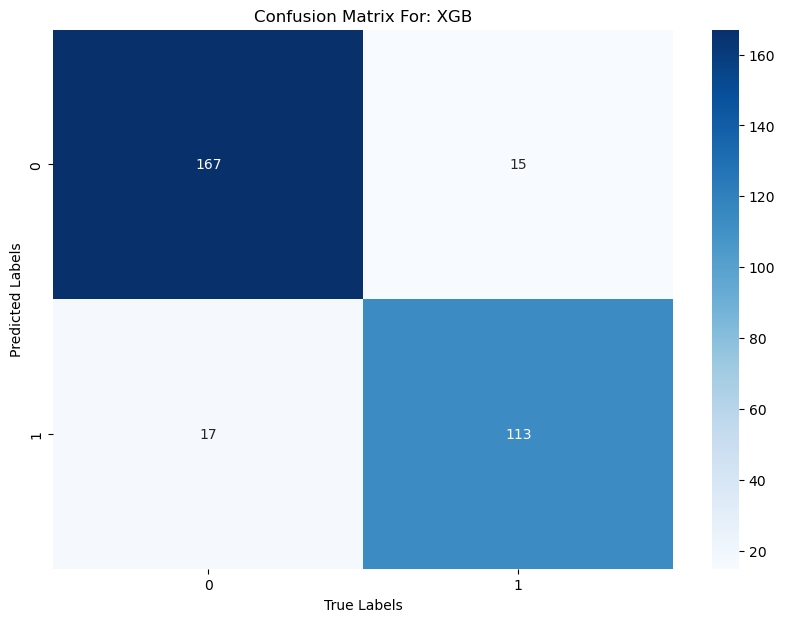

The Best Param: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
  Model  Test-Acc  F1-Score  recall-Score  precision-Score
1   GBC  0.929487  0.929562      0.929487         0.929714
0   RFC  0.923077  0.923077      0.923077         0.923077
2   XGB  0.897436  0.897319      0.897436         0.897277


In [97]:

model_names = ["RFC", "GBC", "XGB"]
models = grab_selected_models(model_names)
performance_df = optimization_search(sample_model, model_names, models, X, y, RandomizedSearchCV, params, f1_metric, kbest)
print(performance_df.sort_values(by="Test-Acc", ascending=False))

# Best Model Params:

- XGB: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.6}
- GBC: {'model__n_estimators': 200, 'model__min_samples_split': 4, 'model__min_samples_leaf': 2, 'model__max_depth': 5, 'model__learning_rate': 0.01}
- RFC: The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': 10, 'model__criterion': 'entropy'}
- KNN: 'model__weights': 'uniform', 'model__p': 2, 'model__n_neighbors': 3, 'model__leaf_size': 50, 'model__algorithm': 'kd_tree'
- LR: {'model__solver': 'saga', 'model__penalty': 'l2', 'model__C': 0.1}
- SVC:{'model__kernel': 'rbf', 'model__gamma': 'auto', 'model__degree': 4, 'model__C': 0.1}

# Voting Classifier

In [98]:
best_models = [
  ("XGB", XGBClassifier(subsample=0.8, n_estimators=100, max_depth=5, learning_rate=0.05, colsample_bytree=0.6)),
  ("GBC", GradientBoostingClassifier(n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_depth=5, learning_rate=0.01)),
  ("RFC", RandomForestClassifier(n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_depth=4, criterion='entropy')),
  ("KNN", KNeighborsClassifier(weights='uniform', p=2, n_neighbors=3, leaf_size=50, algorithm='kd_tree')),
  ("LR", LogisticRegression(solver="saga", penalty='l2', C=0.1)),
  ("SVC", SVC(kernel='rbf', gamma="auto", degree=4, C=0.1, probability=True))
]

# Soft Test

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('PowerTransformer', PowerTransformer()),
                ('Feature-Selector',
                 SelectKBest(k=4,
                             score_func=<function mutual_info_classif at 0x323130f70>)),
                ('sample', SMOTE()),
                ('model',
                 VotingClassifier(estimators=[('XGB',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample...
                                                                          min_samples_split=4,
                                                     

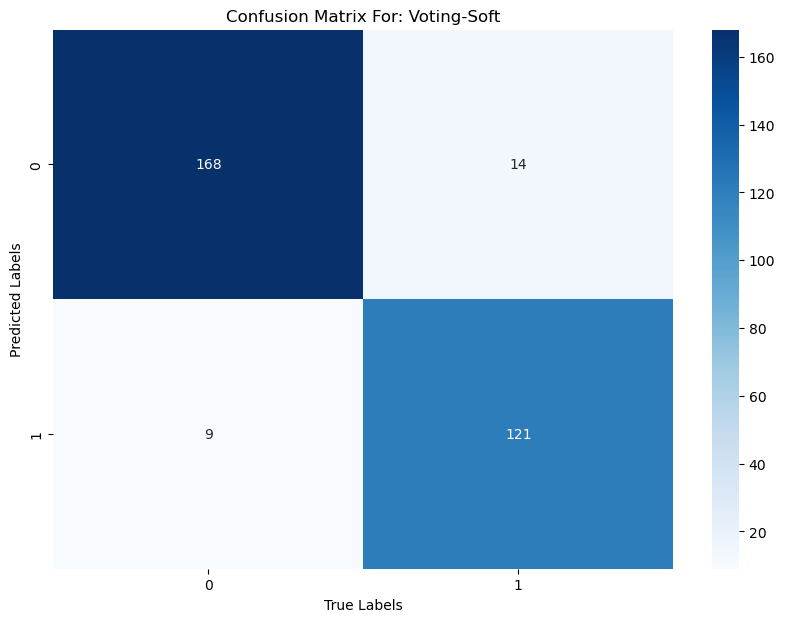

,Model,Test-Acc,F1-Score,recall-Score,precision-Score
0,Voting-Soft,0.926282,0.926464,0.926282,0.927129


In [99]:
clf = VotingClassifier(estimators=best_models,voting="soft")
test_voting_classifier(X,y, clf, sample_model, kbest, "Voting-Soft")

# Hard Voting

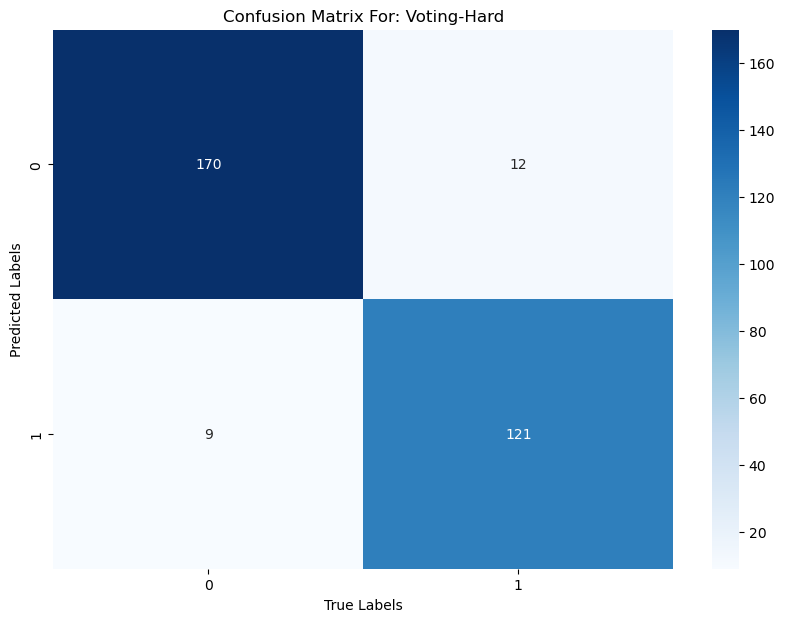

,Model,Test-Acc,F1-Score,recall-Score,precision-Score
0,Voting-Hard,0.932692,0.932797,0.932692,0.933076


In [107]:
clf = VotingClassifier(estimators=best_models,voting="hard")
test_voting_classifier(X,y, clf, sample_model, kbest, "Voting-Hard")

# ROC-AUC Curve

The AUC is: 0.98


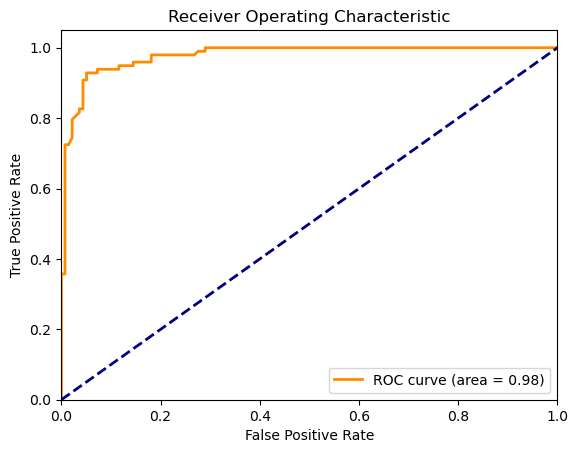

In [111]:
clf = VotingClassifier(estimators=best_models,voting="soft")
plot_roc_curve(X, y, sample_model, clf, kbest)